# Train a Mini-GPT from Scratch

## Watch a Language Model Learn

---

## The Best Way to Understand: Build and Train

Reading about transformers is one thing. **Watching one learn** is another.

In this notebook, we'll:

1. **Build a Mini-GPT** - Small enough to train on CPU/single GPU
2. **Prepare Training Data** - Shakespeare (classic choice)
3. **Train from Scratch** - Watch the loss curve drop
4. **Visualize Learning** - See attention patterns emerge
5. **Generate Text** - Watch quality improve during training
6. **Experiment** - What happens when we change things?

By the end, you'll have **intuition** for how these models actually learn.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.gridspec as gridspec
import numpy as np
import math
import time
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.9.0+cu126
Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


---

## 1. The Mini-GPT Architecture

We'll build a small but complete GPT:

| Parameter | Value | Why |
|-----------|-------|-----|
| Layers | 6 | Deep enough to learn patterns |
| Heads | 6 | Multiple attention patterns |
| Embedding | 384 | Enough capacity |
| Context | 256 | Reasonable sequence length |
| **Total Params** | **~10M** | Trainable on laptop |

In [2]:
@dataclass
class MiniGPTConfig:
    """
    Configuration for Mini-GPT.

    Small enough to train quickly, big enough to learn interesting patterns.
    """
    # Model architecture
    vocab_size: int = 256  # Character-level (all bytes)
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    block_size: int = 256  # Context length

    # Regularization
    dropout: float = 0.1

    # Training
    batch_size: int = 64
    learning_rate: float = 3e-4
    max_iters: int = 5000
    eval_interval: int = 250
    eval_iters: int = 50

    @property
    def head_dim(self):
        return self.n_embd // self.n_head


config = MiniGPTConfig()

# Calculate parameters
def count_parameters(config):
    """Estimate parameter count."""
    # Embeddings
    emb = config.vocab_size * config.n_embd  # Token
    emb += config.block_size * config.n_embd  # Position

    # Per layer
    attn = 4 * config.n_embd * config.n_embd  # Q, K, V, O projections
    ffn = 2 * config.n_embd * (4 * config.n_embd)  # Up and down
    ln = 4 * config.n_embd  # 2 layer norms
    layer = attn + ffn + ln

    # Total
    total = emb + config.n_layer * layer + 2 * config.n_embd  # Final LN
    return total

print("Mini-GPT Configuration")
print("=" * 50)
print(f"Layers: {config.n_layer}")
print(f"Heads: {config.n_head}")
print(f"Embedding dim: {config.n_embd}")
print(f"Head dim: {config.head_dim}")
print(f"Context length: {config.block_size}")
print(f"Vocab size: {config.vocab_size}")
print(f"\nEstimated parameters: {count_parameters(config):,}")

Mini-GPT Configuration
Layers: 6
Heads: 6
Embedding dim: 384
Head dim: 64
Context length: 256
Vocab size: 256

Estimated parameters: 10,823,424


In [3]:
class CausalSelfAttention(nn.Module):
    """
    Multi-head causal self-attention.
    """

    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.head_dim

        # Combined QKV projection
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        # Causal mask
        self.register_buffer(
            'mask',
            torch.tril(torch.ones(config.block_size, config.block_size))
                .view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape

        # Calculate Q, K, V
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)

        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # Attention scores
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        # Apply attention to values
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


class MLP(nn.Module):
    """
    Feed-forward network with GELU activation.
    """

    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.c_fc(x)
        x = F.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    Transformer block with pre-norm.
    """

    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class MiniGPT(nn.Module):
    """
    Mini-GPT Language Model.
    """

    def __init__(self, config: MiniGPTConfig):
        super().__init__()
        self.config = config

        # Embeddings
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.block_size, config.n_embd)
        self.drop = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])

        # Final layer norm and head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight tying
        self.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)

        # Special scaled init for residual projections
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

        # Count parameters
        n_params = sum(p.numel() for p in self.parameters())
        print(f"MiniGPT initialized: {n_params:,} parameters")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor = None):
        B, T = idx.shape
        assert T <= self.config.block_size, f"Sequence too long: {T} > {self.config.block_size}"

        # Embeddings
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        tok_emb = self.wte(idx)
        pos_emb = self.wpe(pos)
        x = self.drop(tok_emb + pos_emb)

        # Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Output
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # Loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx: torch.Tensor, max_new_tokens: int,
                 temperature: float = 1.0, top_k: int = None) -> torch.Tensor:
        """
        Generate tokens autoregressively.
        """
        for _ in range(max_new_tokens):
            # Crop to block size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            # Sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)

        return idx


# Create model
model = MiniGPT(config).to(device)

MiniGPT initialized: 10,844,160 parameters


---

## 2. Prepare the Training Data

We'll use **Shakespeare** - a classic choice for character-level language models.

Why Shakespeare?
- Small enough to train quickly (~1MB)
- Distinctive style (easy to see when model learns)
- Rich patterns (prose, verse, dialogue)

In [4]:
# Shakespeare text (subset for training)
SHAKESPEARE_TEXT = """
ROMEO AND JULIET

ACT I

PROLOGUE

Two households, both alike in dignity,
In fair Verona, where we lay our scene,
From ancient grudge break to new mutiny,
Where civil blood makes civil hands unclean.
From forth the fatal loins of these two foes
A pair of star-cross'd lovers take their life;
Whose misadventured piteous overthrows
Do with their death bury their parents' strife.
The fearful passage of their death-mark'd love,
And the continuance of their parents' rage,
Which, but their children's end, nought could remove,
Is now the two hours' traffic of our stage;
The which if you with patient ears attend,
What here shall miss, our toil shall strive to mend.

SCENE I. Verona. A public place.

Enter SAMPSON and GREGORY, of the house of Capulet, armed with swords and bucklers

SAMPSON:
Gregory, o' my word, we'll not carry coals.

GREGORY:
No, for then we should be colliers.

SAMPSON:
I mean, an we be in choler, we'll draw.

GREGORY:
Ay, while you live, draw your neck out o' the collar.

SAMPSON:
I strike quickly, being moved.

GREGORY:
But thou art not quickly moved to strike.

SAMPSON:
A dog of the house of Montague moves me.

GREGORY:
To move is to stir; and to be valiant is to stand:
therefore, if thou art moved, thou runn'st away.

SAMPSON:
A dog of that house shall move me to stand: I will
take the wall of any man or maid of Montague's.

GREGORY:
That shows thee a weak slave; for the weakest goes
to the wall.

SAMPSON:
True; and therefore women, being the weaker vessels,
are ever thrust to the wall: therefore I will push
Montague's men from the wall, and thrust his maids
to the wall.

GREGORY:
The quarrel is between our masters and us their men.

SAMPSON:
'Tis all one, I will show myself a tyrant: when I
have fought with the men, I will be cruel with the
maids, and cut off their heads.

GREGORY:
The heads of the maids?

SAMPSON:
Ay, the heads of the maids, or their maidenheads;
take it in what sense thou wilt.

GREGORY:
They must take it in sense that feel it.

SAMPSON:
Me they shall feel while I am able to stand: and
'tis known I am a pretty piece of flesh.

GREGORY:
'Tis well thou art not fish; if thou hadst, thou
hadst been poor John. Draw thy tool! here comes
two of the house of the Montagues.

SAMPSON:
My naked weapon is out: quarrel, I will back thee.

GREGORY:
How! turn thy back and run?

SAMPSON:
Fear me not.

GREGORY:
No, marry; I fear thee!

SAMPSON:
Let us take the law of our sides; let them begin.

GREGORY:
I will frown as I pass by, and let them take it as
they list.

SAMPSON:
Nay, as they dare. I will bite my thumb at them;
which is a disgrace to them, if they bear it.

Enter ABRAHAM and BALTHASAR

ABRAHAM:
Do you bite your thumb at us, sir?

SAMPSON:
I do bite my thumb, sir.

ABRAHAM:
Do you bite your thumb at us, sir?

SAMPSON:
[Aside to GREGORY] Is the law of our side, if I say ay?

GREGORY:
No.

SAMPSON:
No, sir, I do not bite my thumb at you, sir, but I
bite my thumb, sir.

GREGORY:
Do you quarrel, sir?

ABRAHAM:
Quarrel sir! no, sir.

SAMPSON:
If you do, sir, I am for you: I serve as good a man as you.

ABRAHAM:
No better.

SAMPSON:
Well, sir.

GREGORY:
Say 'better:' here comes one of my master's kinsmen.

SAMPSON:
Yes, better, sir.

ABRAHAM:
You lie.

SAMPSON:
Draw, if you be men. Gregory, remember thy swashing blow.

They fight

Enter BENVOLIO

BENVOLIO:
Part, fools!
Put up your swords; you know not what you do.

Beats down their swords

Enter TYBALT

TYBALT:
What, art thou drawn among these heartless hinds?
Turn thee, Benvolio, look upon thy death.

BENVOLIO:
I do but keep the peace: put up thy sword,
Or manage it to part these men with me.

TYBALT:
What, drawn, and talk of peace! I hate the word,
As I hate hell, all Montagues, and thee:
Have at thee, coward!

They fight

Enter, several of both houses, who join the fray; then enter Citizens, with clubs

First Citizen:
Clubs, bills, and partisans! strike! beat them down!
Down with the Capulets! down with the Montagues!

Enter CAPULET in his gown, and LADY CAPULET

CAPULET:
What noise is this? Give me my long sword, ho!

LADY CAPULET:
A crutch, a crutch! why call you for a sword?

CAPULET:
My sword, I say! Old Montague is come,
And flourishes his blade in spite of me.

Enter MONTAGUE and LADY MONTAGUE

MONTAGUE:
Thou villain Capulet,--Hold me not, let me go.

LADY MONTAGUE:
Thou shalt not stir a foot to seek a foe.

Enter PRINCE, with Attendants

PRINCE:
Rebellious subjects, enemies to peace,
Profaners of this neighbour-stained steel,--
Will they not hear? What, ho! you men, you beasts,
That quench the fire of your pernicious rage
With purple fountains issuing from your veins,
On pain of torture, from those bloody hands
Throw your mistemper'd weapons to the ground,
And hear the sentence of your moved prince.
Three civil brawls, bred of an airy word,
By thee, old Capulet, and Montague,
Have thrice disturb'd the quiet of our streets,
And made Verona's ancient citizens
Cast by their grave beseeming ornaments,
To wield old partisans, in hands as old,
Canker'd with peace, to part your canker'd hate:
If ever you disturb our streets again,
Your lives shall pay the forfeit of the peace.
For this time, all the rest depart away:
You Capulet; shall go along with me:
And, Montague, come you this afternoon,
To know our further pleasure in this case,
To old Free-town, our common judgment-place.
Once more, on pain of death, all men depart.

Exeunt all but MONTAGUE, LADY MONTAGUE, and BENVOLIO

MONTAGUE:
Who set this ancient quarrel new abroach?
Speak, nephew, were you by when it began?

BENVOLIO:
Here were the servants of your adversary,
And yours, close fighting ere I did approach:
I drew to part them: in the instant came
The fiery Tybalt, with his sword prepared,
Which, as he breathed defiance to my ears,
He swung about his head and cut the winds,
Who nothing hurt withal hiss'd him in scorn:
While we were interchanging thrusts and blows,
Came more and more and fought on part and part,
Till the prince came, who parted either part.

LADY MONTAGUE:
O, where is Romeo? saw you him to-day?
Right glad I am he was not at this fray.

BENVOLIO:
Madam, an hour before the worshipp'd sun
Peer'd forth the golden window of the east,
A troubled mind drave me to walk abroad;
Where, underneath the grove of sycamore
That westward rooteth from the city's side,
So early walking did I see your son:
Towards him I made, but he was ware of me
And stole into the covert of the wood:
I, measuring his affections by my own,
That most are busied when they're most alone,
Pursued my humour not pursuing his,
And gladly shunn'd who gladly fled from me.

MONTAGUE:
Many a morning hath he there been seen,
With tears augmenting the fresh morning dew.
Adding to clouds more clouds with his deep sighs;
But all so soon as the all-cheering sun
Should in the furthest east begin to draw
The shady curtains from Aurora's bed,
Away from the light steals home my heavy son,
And private in his chamber pens himself,
Shuts up his windows, locks far daylight out
And makes himself an artificial night:
Black and portentous must this humour prove,
Unless good counsel may the cause remove.

BENVOLIO:
My noble uncle, do you know the cause?

MONTAGUE:
I neither know it nor can learn of him.

BENVOLIO:
Have you importuned him by any means?

MONTAGUE:
Both by myself and many other friends:
But he, his own affections' counsellor,
Is to himself--I will not say how true--
But to himself so secret and so close,
So far from sounding and discovery,
As is the bud bit with an envious worm,
Ere he can spread his sweet leaves to the air,
Or dedicate his beauty to the sun.
Could we but learn from whence his sorrows grow.
We would as willingly give cure as know.

Enter ROMEO

BENVOLIO:
See, where he comes: so please you, step aside;
I'll know his grievance, or be much denied.

MONTAGUE:
I would thou wert so happy by thy stay,
To hear true shrift. Come, madam, let's away.

Exeunt MONTAGUE and LADY MONTAGUE

BENVOLIO:
Good-morrow, cousin.

ROMEO:
Is the day so young?

BENVOLIO:
But new struck nine.

ROMEO:
Ay me! sad hours seem long.
Was that my father that went hence so fast?

BENVOLIO:
It was. What sadness lengthens Romeo's hours?

ROMEO:
Not having that, which, having, makes them short.

BENVOLIO:
In love?

ROMEO:
Out--

BENVOLIO:
Of love?

ROMEO:
Out of her favour, where I am in love.

BENVOLIO:
Alas, that love, so gentle in his view,
Should be so tyrannous and rough in proof!

ROMEO:
Alas, that love, whose view is muffled still,
Should, without eyes, see pathways to his will!
Where shall we dine? O me! What fray was here?
Yet tell me not, for I have heard it all.
Here's much to do with hate, but more with love.
Why, then, O brawling love! O loving hate!
O any thing, of nothing first create!
O heavy lightness! serious vanity!
Mis-shapen chaos of well-seeming forms!
Feather of lead, bright smoke, cold fire, sick health!
Still-waking sleep, that is not what it is!
This love feel I, that feel no love in this.
Dost thou not laugh?

BENVOLIO:
No, coz, I rather weep.

ROMEO:
Good heart, at what?

BENVOLIO:
At thy good heart's oppression.

ROMEO:
Why, such is love's transgression.
Griefs of mine own lie heavy in my breast,
Which thou wilt propagate, to have it prest
With more of thine: this love that thou hast shown
Doth add more grief to too much of mine own.
Love is a smoke raised with the fume of sighs;
Being purged, a fire sparkling in lovers' eyes;
Being vex'd a sea nourish'd with lovers' tears:
What is it else? a madness most discreet,
A choking gall and a preserving sweet.
Farewell, my coz.

BENVOLIO:
Soft! I will go along;
An if you leave me so, you do me wrong.

ROMEO:
Tut, I have lost myself; I am not here;
This is not Romeo, he's some other where.

BENVOLIO:
Tell me in sadness, who is that you love.

ROMEO:
What, shall I groan and tell thee?

BENVOLIO:
Groan! why, no. But sadly tell me who.

ROMEO:
Bid a sick man in sadness make his will:
Ah, word ill urged to one that is so ill!
In sadness, cousin, I do love a woman.

BENVOLIO:
I aim'd so near, when I supposed you loved.

ROMEO:
A right good mark-man! And she's fair I love.

BENVOLIO:
A right fair mark, fair coz, is soonest hit.

ROMEO:
Well, in that hit you miss: she'll not be hit
With Cupid's arrow; she hath Dian's wit;
And, in strong proof of chastity well arm'd,
From love's weak childish bow she lives unharm'd.
She will not stay the siege of loving terms,
Nor bide the encounter of assailing eyes,
Nor ope her lap to saint-seducing gold:
O, she is rich in beauty, only poor,
That when she dies with beauty dies her store.

BENVOLIO:
Then she hath sworn that she will still live chaste?

ROMEO:
She hath, and in that sparing makes huge waste,
For beauty starved with her severity
Cuts beauty off from all posterity.
She is too fair, too wise, wisely too fair,
To merit bliss by making me despair:
She hath forsworn to love, and in that vow
Do I live dead that live to tell it now.

BENVOLIO:
Be ruled by me, forget to think of her.

ROMEO:
O, teach me how I should forget to think.

BENVOLIO:
By giving liberty unto thine eyes;
Examine other beauties.

ROMEO:
'Tis the way
To call hers exquisite, in question more:
These happy masks that kiss fair ladies' brows
Being black put us in mind they hide the fair;
He that is strucken blind cannot forget
The precious treasure of his eyesight lost:
Show me a mistress that is passing fair,
What doth her beauty serve, but as a note
Where I may read who pass'd that passing fair?
Farewell: thou canst not teach me to forget.

BENVOLIO:
I'll pay that doctrine, or else die in debt.
"""

# Repeat to make it larger for training
text = SHAKESPEARE_TEXT * 5

print(f"Training text length: {len(text):,} characters")
print(f"Unique characters: {len(set(text))}")
print(f"\nSample:")
print(text[:500])

Training text length: 57,845 characters
Unique characters: 61

Sample:

ROMEO AND JULIET

ACT I

PROLOGUE

Two households, both alike in dignity,
In fair Verona, where we lay our scene,
From ancient grudge break to new mutiny,
Where civil blood makes civil hands unclean.
From forth the fatal loins of these two foes
A pair of star-cross'd lovers take their life;
Whose misadventured piteous overthrows
Do with their death bury their parents' strife.
The fearful passage of their death-mark'd love,
And the continuance of their parents' rage,
Which, but their children's 


In [5]:
class CharDataset(Dataset):
    """
    Character-level dataset for language modeling.
    """

    def __init__(self, text: str, block_size: int):
        self.block_size = block_size

        # Character-level encoding (simple: use byte values)
        self.data = torch.tensor([ord(c) for c in text], dtype=torch.long)

        print(f"Dataset: {len(self.data):,} tokens, {len(self)} sequences")

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.block_size]
        y = self.data[idx + 1:idx + self.block_size + 1]
        return x, y


def encode(text: str) -> torch.Tensor:
    """Encode text to tensor."""
    return torch.tensor([ord(c) for c in text], dtype=torch.long)


def decode(tokens: torch.Tensor) -> str:
    """Decode tensor to text."""
    return ''.join([chr(t) for t in tokens.tolist()])


# Create dataset
dataset = CharDataset(text, config.block_size)

# Split into train/val
n = len(dataset)
train_size = int(0.9 * n)
val_size = n - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"\nTrain: {len(train_dataset):,} sequences")
print(f"Val: {len(val_dataset):,} sequences")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# Test
x, y = next(iter(train_loader))
print(f"\nBatch shapes: x={x.shape}, y={y.shape}")
print(f"\nSample input: '{decode(x[0][:50])}...'")
print(f"Sample target: '{decode(y[0][:50])}...'")

Dataset: 57,845 tokens, 57589 sequences

Train: 51,830 sequences
Val: 5,759 sequences

Batch shapes: x=torch.Size([64, 256]), y=torch.Size([64, 256])

Sample input: 'u know not what you do.

Beats down their swords

...'
Sample target: ' know not what you do.

Beats down their swords

E...'


---

## 3. Training Loop

Now the exciting part: **watch the model learn!**

In [6]:
class Trainer:
    """
    Training loop with logging and visualization.
    """

    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config

        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.95),
            weight_decay=0.1
        )

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=config.max_iters
        )

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.samples = []  # Generated text at checkpoints
        self.iter_num = 0

    @torch.no_grad()
    def estimate_loss(self):
        """Estimate loss on train and val sets."""
        self.model.eval()
        losses = {'train': [], 'val': []}

        for split, loader in [('train', self.train_loader), ('val', self.val_loader)]:
            for i, (x, y) in enumerate(loader):
                if i >= self.config.eval_iters:
                    break
                x, y = x.to(device), y.to(device)
                _, loss = self.model(x, y)
                losses[split].append(loss.item())

        self.model.train()
        return {k: np.mean(v) for k, v in losses.items()}

    @torch.no_grad()
    def generate_sample(self, prompt: str = "ROMEO:\n", max_tokens: int = 200):
        """Generate a text sample."""
        self.model.eval()
        idx = encode(prompt).unsqueeze(0).to(device)
        output = self.model.generate(idx, max_new_tokens=max_tokens, temperature=0.8, top_k=40)
        self.model.train()
        return decode(output[0])

    def train_step(self, x, y):
        """Single training step."""
        x, y = x.to(device), y.to(device)

        self.optimizer.zero_grad()
        _, loss = self.model(x, y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

        self.optimizer.step()
        self.scheduler.step()

        return loss.item()

    def train(self, max_iters: int = None):
        """Main training loop."""
        max_iters = max_iters or self.config.max_iters

        self.model.train()
        train_iter = iter(self.train_loader)

        print("Starting training...")
        print("=" * 70)

        start_time = time.time()

        for self.iter_num in range(max_iters):
            # Get batch (cycle through dataset)
            try:
                x, y = next(train_iter)
            except StopIteration:
                train_iter = iter(self.train_loader)
                x, y = next(train_iter)

            # Train step
            loss = self.train_step(x, y)

            # Track learning rate
            lr = self.scheduler.get_last_lr()[0]
            self.learning_rates.append(lr)

            # Evaluation
            if self.iter_num % self.config.eval_interval == 0 or self.iter_num == max_iters - 1:
                losses = self.estimate_loss()
                self.train_losses.append((self.iter_num, losses['train']))
                self.val_losses.append((self.iter_num, losses['val']))

                elapsed = time.time() - start_time

                print(f"Iter {self.iter_num:5d} | "
                      f"Train loss: {losses['train']:.4f} | "
                      f"Val loss: {losses['val']:.4f} | "
                      f"LR: {lr:.2e} | "
                      f"Time: {elapsed:.1f}s")

                # Generate sample
                sample = self.generate_sample()
                self.samples.append((self.iter_num, sample))

        print("\nTraining complete!")
        return self.train_losses, self.val_losses

In [7]:
# Create trainer
trainer = Trainer(model, train_loader, val_loader, config)

# Generate before training
print("BEFORE TRAINING:")
print("-" * 50)
sample_before = trainer.generate_sample("ROMEO:\n", max_tokens=150)
print(sample_before)
print("-" * 50)

BEFORE TRAINING:
--------------------------------------------------
ROMEO:
èÑOrû"qRIr®*»¶¿3-Z|ÊãÙð_þc''Är³ðëãëöark|Wf·ºµ$¬ëÛãðªEr)<ÒÑsËëcK\G¾èaíÄtt¾ð;ÈffÛØÑ**Ñ*±ZèªÜls=ÜZZ6 Ïrf*-¶¶²¶Ê
--------------------------------------------------


In [8]:
# TRAIN THE MODEL!
train_losses, val_losses = trainer.train(max_iters=config.max_iters)

Starting training...
Iter     0 | Train loss: 4.4831 | Val loss: 4.4832 | LR: 3.00e-04 | Time: 14.1s
Iter   250 | Train loss: 1.1315 | Val loss: 1.1333 | LR: 2.98e-04 | Time: 139.9s
Iter   500 | Train loss: 0.0956 | Val loss: 0.0975 | LR: 2.93e-04 | Time: 271.0s
Iter   750 | Train loss: 0.0539 | Val loss: 0.0553 | LR: 2.84e-04 | Time: 403.0s
Iter  1000 | Train loss: 0.0423 | Val loss: 0.0432 | LR: 2.71e-04 | Time: 535.3s
Iter  1250 | Train loss: 0.0378 | Val loss: 0.0389 | LR: 2.56e-04 | Time: 667.1s
Iter  1500 | Train loss: 0.0347 | Val loss: 0.0357 | LR: 2.38e-04 | Time: 799.5s
Iter  1750 | Train loss: 0.0325 | Val loss: 0.0336 | LR: 2.18e-04 | Time: 931.6s
Iter  2000 | Train loss: 0.0313 | Val loss: 0.0326 | LR: 1.96e-04 | Time: 1063.6s
Iter  2250 | Train loss: 0.0301 | Val loss: 0.0310 | LR: 1.73e-04 | Time: 1195.8s
Iter  2500 | Train loss: 0.0294 | Val loss: 0.0302 | LR: 1.50e-04 | Time: 1327.9s
Iter  2750 | Train loss: 0.0281 | Val loss: 0.0294 | LR: 1.26e-04 | Time: 1459.9s
Iter

In [9]:
# Generate after training
print("\nAFTER TRAINING:")
print("-" * 50)
sample_after = trainer.generate_sample("ROMEO:\n", max_tokens=300)
print(sample_after)
print("-" * 50)


AFTER TRAINING:
--------------------------------------------------
ROMEO:
Ay me! sad hours seem long.
Was that my father that went hence so fast?

BENVOLIO:
It was. What sadness lengthens Romeo's hours?

ROMEO:
Not having that, which, having, makes them short.

BENVOLIO:
In love?

ROMEO:
Out--

BENVOLIO:
Of love?

ROMEO:
Out of her favour, where I am in love.

BENVOLIO:
A
--------------------------------------------------


---

## 4. Visualize the Learning Process

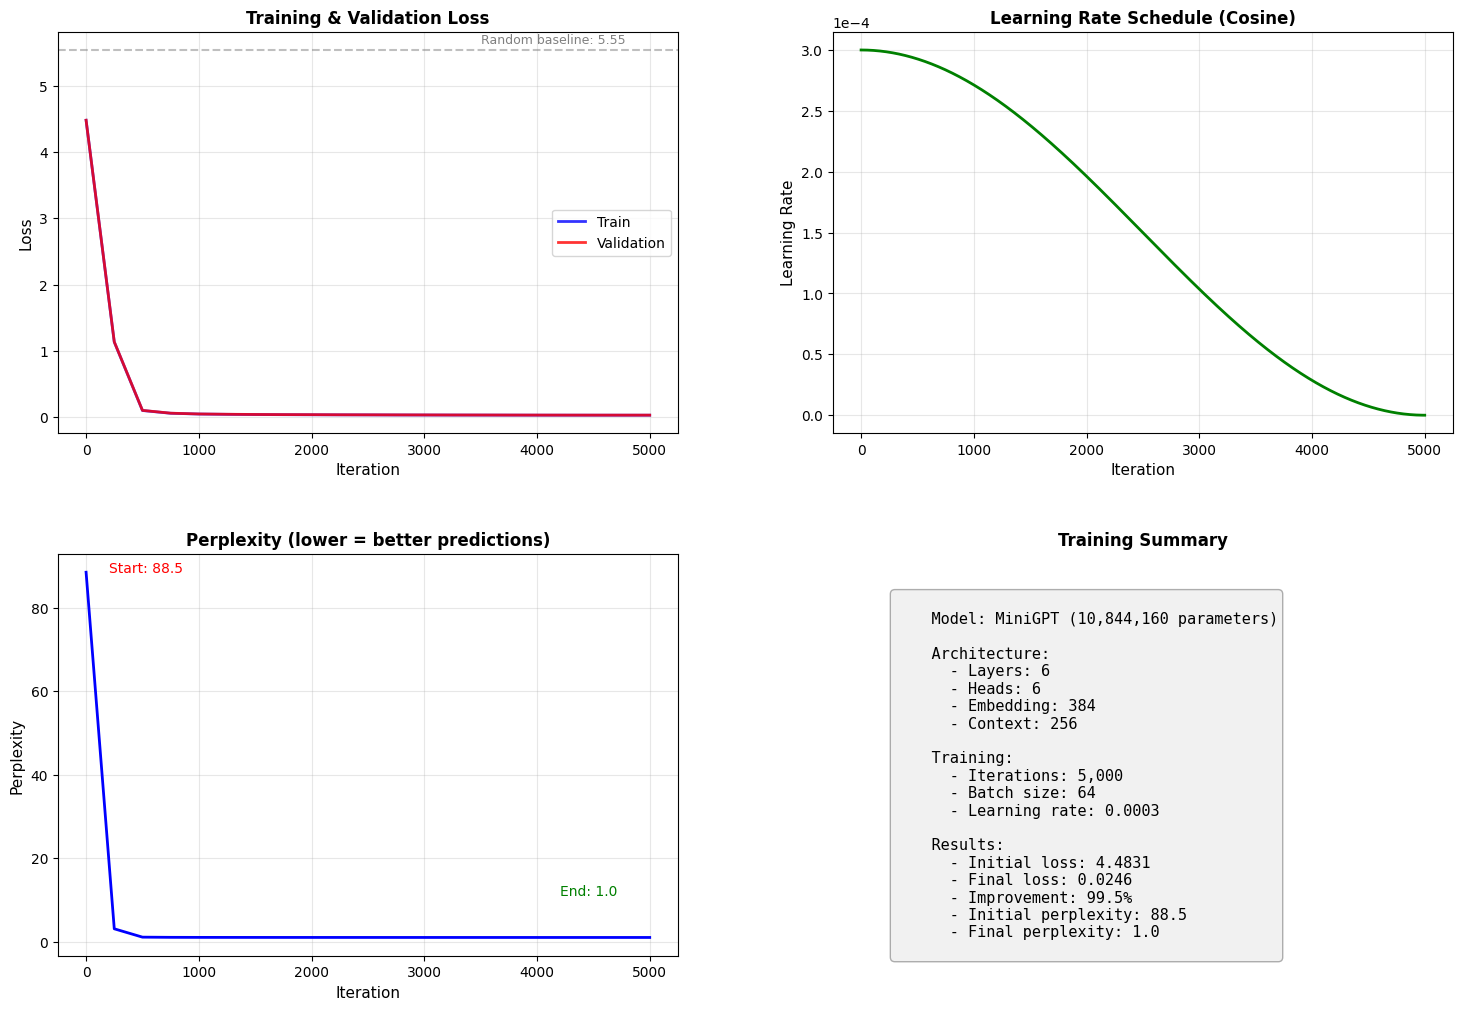

In [10]:
def plot_training_progress(trainer):
    """
    Comprehensive visualization of training progress.
    """
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.25)

    # === TOP LEFT: Loss curves ===
    ax1 = fig.add_subplot(gs[0, 0])

    train_iters, train_loss = zip(*trainer.train_losses)
    val_iters, val_loss = zip(*trainer.val_losses)

    ax1.plot(train_iters, train_loss, 'b-', linewidth=2, label='Train', alpha=0.8)
    ax1.plot(val_iters, val_loss, 'r-', linewidth=2, label='Validation', alpha=0.8)

    ax1.set_xlabel('Iteration', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Random baseline
    random_loss = np.log(config.vocab_size)
    ax1.axhline(y=random_loss, color='gray', linestyle='--', alpha=0.5)
    ax1.text(train_iters[-1] * 0.7, random_loss + 0.1, f'Random baseline: {random_loss:.2f}',
             fontsize=9, color='gray')

    # === TOP RIGHT: Learning rate ===
    ax2 = fig.add_subplot(gs[0, 1])

    ax2.plot(trainer.learning_rates, 'g-', linewidth=2)
    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Learning Rate', fontsize=11)
    ax2.set_title('Learning Rate Schedule (Cosine)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # === BOTTOM LEFT: Loss improvement ===
    ax3 = fig.add_subplot(gs[1, 0])

    initial_loss = train_loss[0]
    final_loss = train_loss[-1]
    improvement = (initial_loss - final_loss) / initial_loss * 100

    perplexities = [np.exp(l) for l in train_loss]
    ax3.plot(train_iters, perplexities, 'b-', linewidth=2)
    ax3.set_xlabel('Iteration', fontsize=11)
    ax3.set_ylabel('Perplexity', fontsize=11)
    ax3.set_title('Perplexity (lower = better predictions)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Annotate
    ax3.annotate(f'Start: {perplexities[0]:.1f}', xy=(train_iters[0], perplexities[0]),
                 xytext=(train_iters[0] + 200, perplexities[0]),
                 fontsize=10, color='red')
    ax3.annotate(f'End: {perplexities[-1]:.1f}', xy=(train_iters[-1], perplexities[-1]),
                 xytext=(train_iters[-1] - 800, perplexities[-1] + 10),
                 fontsize=10, color='green')

    # === BOTTOM RIGHT: Summary stats ===
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    ax4.set_title('Training Summary', fontsize=12, fontweight='bold')

    summary = f"""
    Model: MiniGPT ({sum(p.numel() for p in model.parameters()):,} parameters)

    Architecture:
      - Layers: {config.n_layer}
      - Heads: {config.n_head}
      - Embedding: {config.n_embd}
      - Context: {config.block_size}

    Training:
      - Iterations: {config.max_iters:,}
      - Batch size: {config.batch_size}
      - Learning rate: {config.learning_rate}

    Results:
      - Initial loss: {initial_loss:.4f}
      - Final loss: {final_loss:.4f}
      - Improvement: {improvement:.1f}%
      - Initial perplexity: {np.exp(initial_loss):.1f}
      - Final perplexity: {np.exp(final_loss):.1f}
    """

    ax4.text(0.1, 0.9, summary, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

    plt.tight_layout()
    plt.show()

plot_training_progress(trainer)

In [11]:
def show_generation_progress(trainer):
    """
    Show how text generation improves during training.
    """
    print("TEXT GENERATION PROGRESS")
    print("=" * 70)

    # Select a few checkpoints
    n_samples = min(5, len(trainer.samples))
    indices = np.linspace(0, len(trainer.samples) - 1, n_samples, dtype=int)

    for i in indices:
        iter_num, sample = trainer.samples[i]

        # Get corresponding loss
        loss_idx = min(i, len(trainer.train_losses) - 1)
        _, loss = trainer.train_losses[loss_idx]

        print(f"\n{'='*70}")
        print(f"Iteration {iter_num} | Loss: {loss:.4f} | Perplexity: {np.exp(loss):.1f}")
        print("=" * 70)
        print(sample[:400])
        if len(sample) > 400:
            print("...")

show_generation_progress(trainer)

TEXT GENERATION PROGRESS

Iteration 0 | Loss: 4.4831 | Perplexity: 88.5
ROMEO:
 s M¢3 ee a óe ¯    0t-3 e  e   M;e   t  0  hó- wtwtt v Êt ó wtûûhchw   û eaÊ   T t r5i5óû f 
f;    fre ee s  ¯s t$ e ¢h  a¨
e5tMtW   sm ¢i e   t h w,3¨-lÊÄ; Moe s    ¨ 0 t lw ûvn  û  dj¯ s

Iteration 1250 | Loss: 0.0378 | Perplexity: 1.0
ROMEO:
Out of her favour, where I am in love.

BENVOLIO:
Alas, that love, so gentle in his view,
Should be so tyrannous and rough in proof!

ROMEO:
Alas, that love, whose view is muffled still,
Should, witho

Iteration 2500 | Loss: 0.0294 | Perplexity: 1.0
ROMEO:
Tut, I have lost myself; I am not here;
This is not Romeo, he's some other where.

BENVOLIO:
Tell me in sadness, who is that you love.

ROMEO:
What, shall I groan and tell thee?

BENVOLIO:
Groan! why,

Iteration 3750 | Loss: 0.0258 | Perplexity: 1.0
ROMEO:
Ay me! sad hours seem long.
Was that my father that went hence so fast?

BENVOLIO:
It was. What sadness lengthens Romeo's hours?

ROMEO:
Not having that, which

---

## 5. Explore the Trained Model

In [12]:
def interactive_generation(model, prompts: List[str], temperatures: List[float] = [0.5, 0.8, 1.0]):
    """
    Generate text with different prompts and temperatures.
    """
    model.eval()

    for prompt in prompts:
        print(f"\n{'='*70}")
        print(f"PROMPT: '{prompt}'")
        print("=" * 70)

        for temp in temperatures:
            print(f"\n[Temperature = {temp}]")
            print("-" * 40)

            idx = encode(prompt).unsqueeze(0).to(device)
            output = model.generate(idx, max_new_tokens=150, temperature=temp, top_k=40)
            text = decode(output[0])

            print(text)


# Test with different prompts
prompts = [
    "JULIET:\n",
    "ROMEO:\nO, ",
    "Enter ",
    "What light ",
]

interactive_generation(model, prompts, temperatures=[0.5, 1.0])


PROMPT: 'JULIET:
'

[Temperature = 0.5]
----------------------------------------
JULIET:
A crutch, a crutch! why call you for a sword?

CAPULET:
My sword, I say! Old Montague is come,
And flourishes his blade in spite of me.

Enter MONTAGU

[Temperature = 1.0]
----------------------------------------
JULIET:
A crutch, a crutch! why call you for a sword?

CAPULET:
My sword, I say! Old Montague is come,
And flourishes his blade in spite of me.

Enter MONTAGU

PROMPT: 'ROMEO:
O, '

[Temperature = 0.5]
----------------------------------------
ROMEO:
O, teach me how I should forget to think.

BENVOLIO:
By giving liberty unto thine eyes;
Examine other beauties.

ROMEO:
'Tis the way
To call hers exquisi

[Temperature = 1.0]
----------------------------------------
ROMEO:
O, teach me how I should forget to think.

BENVOLIO:
By giving liberty unto thine eyes;
Examine other beauties.

ROMEO:
'Tis the way
To call hers exquisi

PROMPT: 'Enter '

[Temperature = 0.5]
-------------------------------

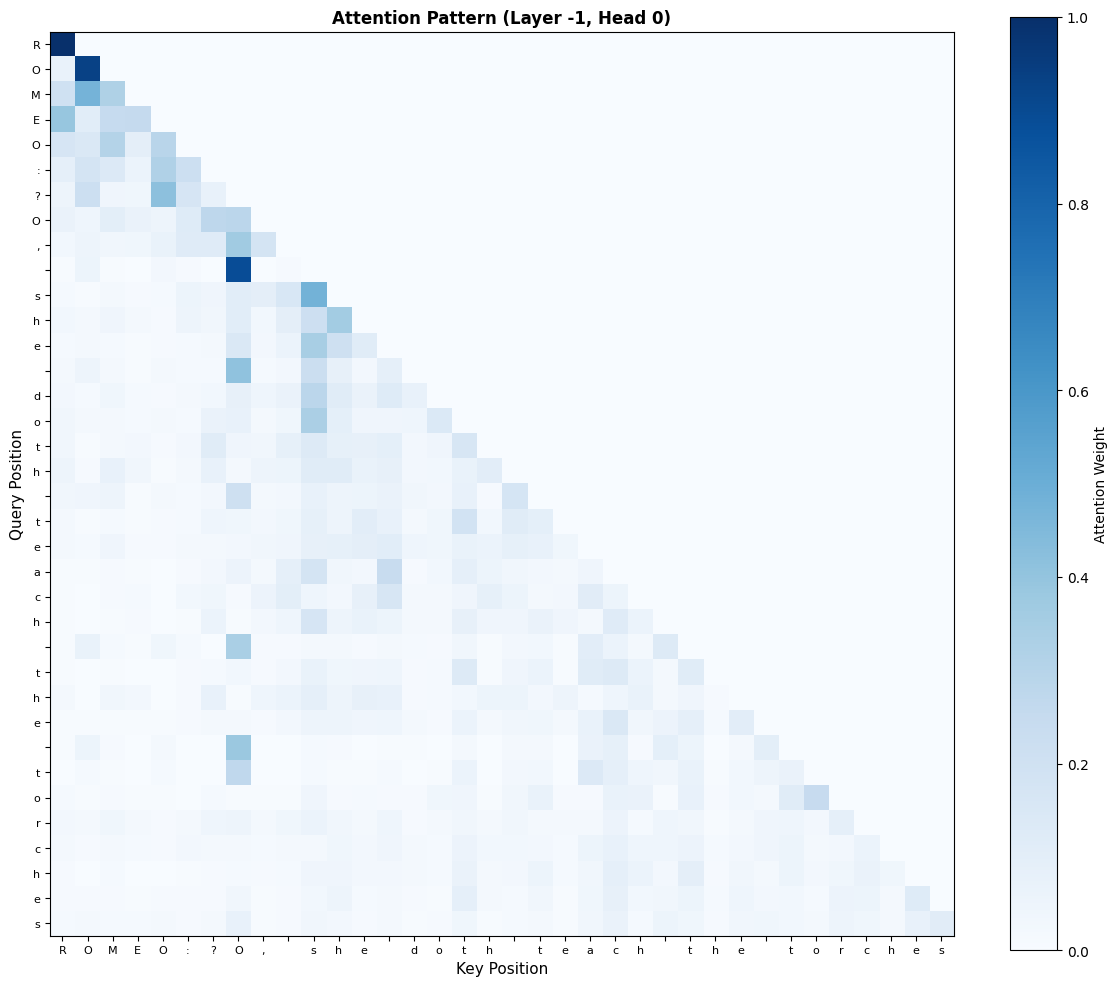

In [13]:
def visualize_attention(model, text: str, layer: int = -1, head: int = 0):
    """
    Visualize attention patterns for a given text.
    """
    model.eval()

    # Encode text
    tokens = encode(text[:50])  # Limit length for visualization
    idx = tokens.unsqueeze(0).to(device)

    # Hook to capture attention
    attention_weights = []

    def hook(module, input, output):
        # Recompute attention for visualization
        B, T, C = input[0].shape
        qkv = module.c_attn(input[0])
        q, k, v = qkv.split(module.n_embd, dim=2)
        q = q.view(B, T, module.n_head, module.head_dim).transpose(1, 2)
        k = k.view(B, T, module.n_head, module.head_dim).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(module.head_dim))
        att = att.masked_fill(module.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        attention_weights.append(att.detach().cpu())

    # Register hook
    target_layer = model.blocks[layer].attn
    handle = target_layer.register_forward_hook(hook)

    # Forward pass
    with torch.no_grad():
        model(idx)

    handle.remove()

    # Get attention for specified head
    attn = attention_weights[0][0, head].numpy()  # [T, T]

    # Create labels (characters)
    chars = [chr(t) if 32 <= t < 127 else '?' for t in tokens.tolist()]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))

    im = ax.imshow(attn, cmap='Blues')
    ax.set_xticks(range(len(chars)))
    ax.set_yticks(range(len(chars)))
    ax.set_xticklabels(chars, fontsize=8)
    ax.set_yticklabels(chars, fontsize=8)

    ax.set_xlabel('Key Position', fontsize=11)
    ax.set_ylabel('Query Position', fontsize=11)
    ax.set_title(f'Attention Pattern (Layer {layer}, Head {head})',
                 fontsize=12, fontweight='bold')

    plt.colorbar(im, ax=ax, label='Attention Weight')
    plt.tight_layout()
    plt.show()

    return attn


# Visualize attention
sample_text = "ROMEO:\nO, she doth teach the torches"
attn = visualize_attention(model, sample_text, layer=-1, head=0)

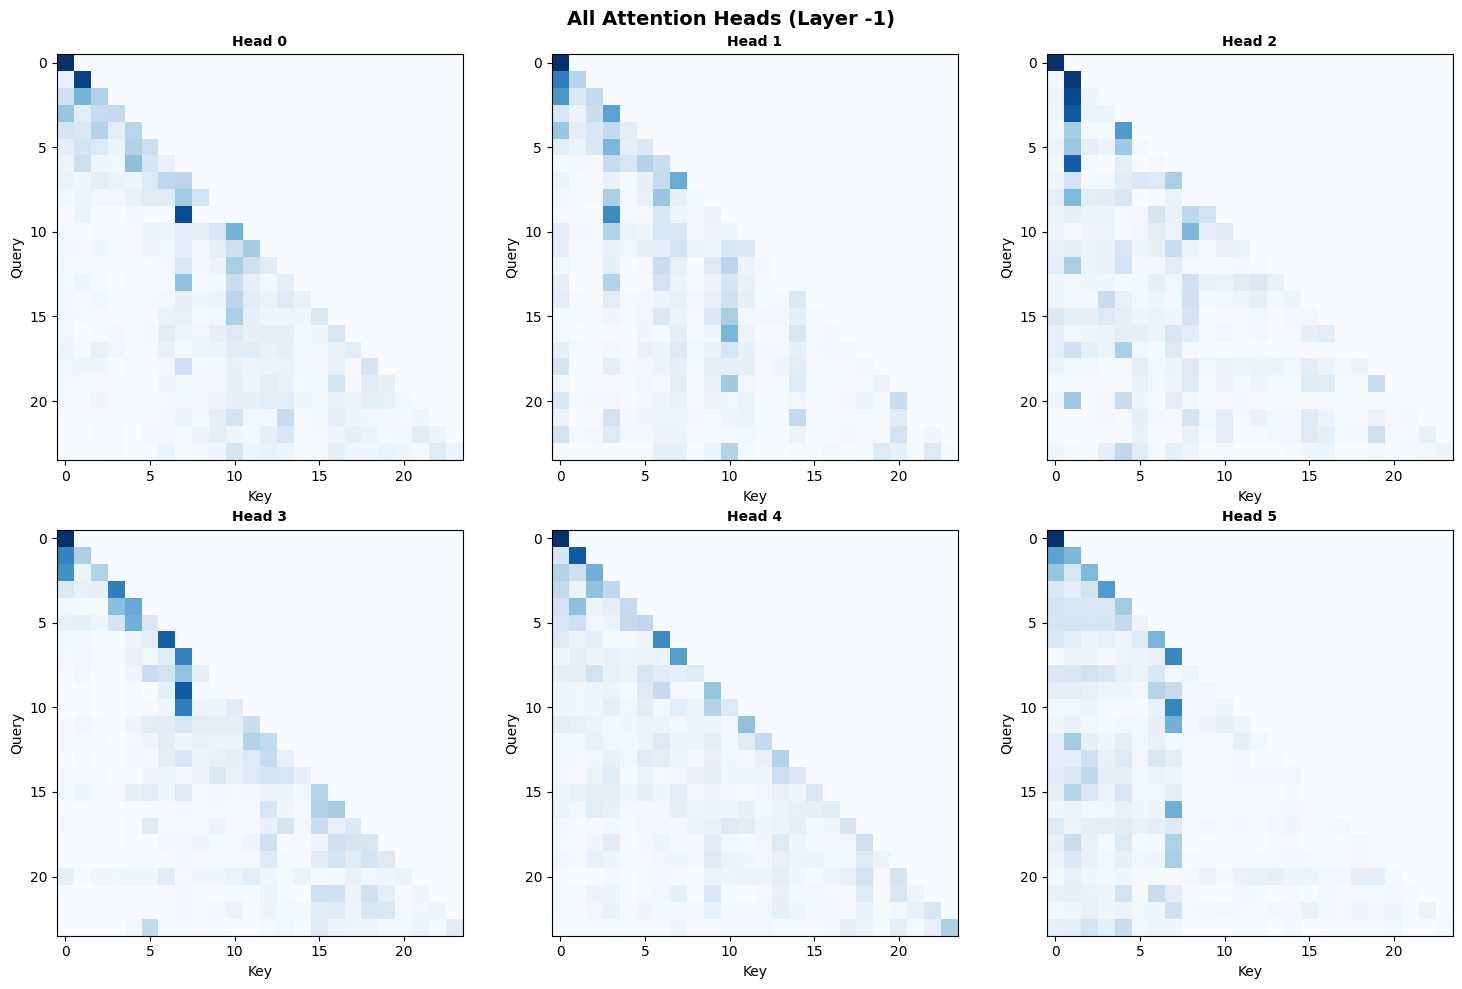

In [14]:
def visualize_all_heads(model, text: str, layer: int = -1):
    """
    Visualize all attention heads in a layer.
    """
    model.eval()

    tokens = encode(text[:30])
    idx = tokens.unsqueeze(0).to(device)

    attention_weights = []

    def hook(module, input, output):
        B, T, C = input[0].shape
        qkv = module.c_attn(input[0])
        q, k, v = qkv.split(module.n_embd, dim=2)
        q = q.view(B, T, module.n_head, module.head_dim).transpose(1, 2)
        k = k.view(B, T, module.n_head, module.head_dim).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(module.head_dim))
        att = att.masked_fill(module.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        attention_weights.append(att.detach().cpu())

    target_layer = model.blocks[layer].attn
    handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        model(idx)

    handle.remove()

    attn = attention_weights[0][0]  # [n_head, T, T]

    # Plot all heads
    n_heads = attn.shape[0]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(min(6, n_heads)):
        ax = axes[i]
        im = ax.imshow(attn[i].numpy(), cmap='Blues')
        ax.set_title(f'Head {i}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')

    plt.suptitle(f'All Attention Heads (Layer {layer})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_all_heads(model, "ROMEO:\nO, she doth teach", layer=-1)

---

## 6. Experiments: What Happens When We Change Things?

### 6.1 Effect of Temperature

In [15]:
def temperature_experiment(model, prompt: str = "ROMEO:\n"):
    """
    Show effect of temperature on generation.
    """
    model.eval()

    temperatures = [0.2, 0.5, 0.8, 1.0, 1.5]

    print("TEMPERATURE EXPERIMENT")
    print(f"Prompt: '{prompt}'")
    print("=" * 70)

    for temp in temperatures:
        print(f"\n[Temperature = {temp}]")
        print("-" * 50)

        idx = encode(prompt).unsqueeze(0).to(device)
        output = model.generate(idx, max_new_tokens=100, temperature=temp, top_k=None)
        text = decode(output[0])

        print(text)

        if temp == 0.2:
            print("\n  ^ Low temperature: More deterministic, repetitive")
        elif temp == 1.5:
            print("\n  ^ High temperature: More random, creative but chaotic")

temperature_experiment(model)

TEMPERATURE EXPERIMENT
Prompt: 'ROMEO:
'

[Temperature = 0.2]
--------------------------------------------------
ROMEO:
Ay me! sad hours seem long.
Was that my father that went hence so fast?

BENVOLIO:
It was. What sadn

  ^ Low temperature: More deterministic, repetitive

[Temperature = 0.5]
--------------------------------------------------
ROMEO:
A right good mark-man! And she's fair I love.

BENVOLIO:
A right fair mark, fair coz, is soonest hit

[Temperature = 0.8]
--------------------------------------------------
ROMEO:
Out--

BENVOLIO:
Of love?

ROMEO:
Out of her favour, where I am in love.

BENVOLIO:
Alas, that love,

[Temperature = 1.0]
--------------------------------------------------
ROMEO:
'Tis the way
To call hers exquisite, in question more:
These happy masks that kiss fair ladies' brow

[Temperature = 1.5]
--------------------------------------------------
ROMEO:
O, teach me how I should forget to think.

BENVOLIO:
By giving liberty unto thine eyes;
Examine othe

  ^ H

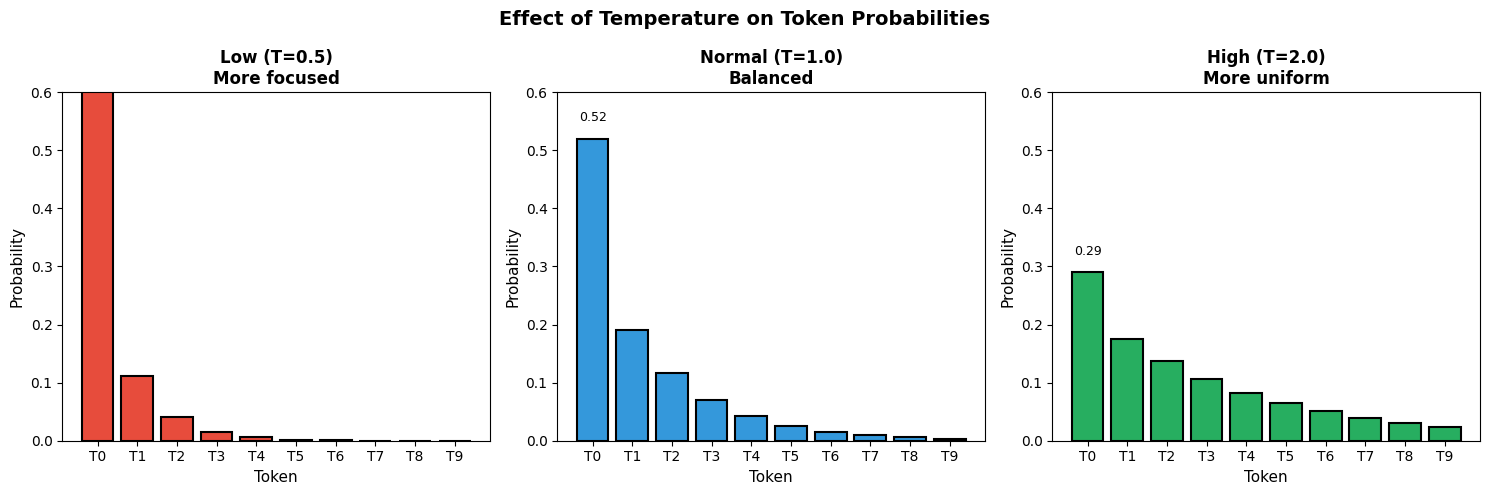

In [16]:
def visualize_temperature_effect():
    """
    Visualize how temperature affects probability distribution.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Simulated logits
    np.random.seed(42)
    logits = np.array([3.0, 2.0, 1.5, 1.0, 0.5, 0.0, -0.5, -1.0, -1.5, -2.0])
    tokens = [f'T{i}' for i in range(len(logits))]

    temperatures = [0.5, 1.0, 2.0]
    titles = ['Low (T=0.5)\nMore focused', 'Normal (T=1.0)\nBalanced', 'High (T=2.0)\nMore uniform']
    colors = ['#e74c3c', '#3498db', '#27ae60']

    for ax, temp, title, color in zip(axes, temperatures, titles, colors):
        probs = np.exp(logits / temp) / np.sum(np.exp(logits / temp))

        ax.bar(tokens, probs, color=color, edgecolor='black', linewidth=1.5)
        ax.set_xlabel('Token', fontsize=11)
        ax.set_ylabel('Probability', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylim(0, 0.6)

        # Annotate top token
        ax.annotate(f'{probs[0]:.2f}', xy=(0, probs[0]),
                    xytext=(0, probs[0] + 0.03), ha='center', fontsize=9)

    plt.suptitle('Effect of Temperature on Token Probabilities', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_temperature_effect()

### 6.2 Effect of Context

In [17]:
def context_experiment(model):
    """
    Show how different prompts lead to different outputs.
    """
    model.eval()

    prompts = [
        # Character-specific prompts
        "ROMEO:\n",
        "JULIET:\n",
        "BENVOLIO:\n",
        "TYBALT:\n",

        # Style prompts
        "Enter ",
        "Exeunt",
        "ACT II\n\n",
    ]

    print("CONTEXT EXPERIMENT")
    print("Different prompts → Different continuations")
    print("=" * 70)

    for prompt in prompts:
        print(f"\nPrompt: '{prompt.strip()}'")
        print("-" * 50)

        idx = encode(prompt).unsqueeze(0).to(device)
        output = model.generate(idx, max_new_tokens=80, temperature=0.8, top_k=40)
        text = decode(output[0])

        print(text)

context_experiment(model)

CONTEXT EXPERIMENT
Different prompts → Different continuations

Prompt: 'ROMEO:'
--------------------------------------------------
ROMEO:
Tut, I have lost myself; I am not here;
This is not Romeo, he's some other where

Prompt: 'JULIET:'
--------------------------------------------------
JULIET:
A crutch, a crutch! why call you for a sword?

CAPULET:
My sword, I say! Old Mon

Prompt: 'BENVOLIO:'
--------------------------------------------------
BENVOLIO:
I aim'd so near, when I supposed you loved.

ROMEO:
A right good mark-man! And s

Prompt: 'TYBALT:'
--------------------------------------------------
TYBALT:
What, drawn, and talk of peace! I hate the word,
As I hate hell, all Montagues, 

Prompt: 'Enter'
--------------------------------------------------
Enter MONTAGUE and LADY MONTAGUE

MONTAGUE:
Thou villain Capulet,--Hold me not, let me

Prompt: 'Exeunt'
--------------------------------------------------
Exeunt MONTAGUE and LADY MONTAGUE

BENVOLIO:
Good-morrow, cousin.

ROMEO:
I

---

## 7. What Did the Model Learn?

Let's analyze what patterns the model picked up.

In [18]:
def analyze_model_knowledge(model):
    """
    Analyze what the model has learned.
    """
    model.eval()

    print("MODEL KNOWLEDGE ANALYSIS")
    print("=" * 70)

    # Test 1: Character names
    print("\n1. CHARACTER NAMES")
    print("-" * 40)

    name_prompts = ["ROM", "JUL", "BEN", "TYB", "CAP"]
    for prompt in name_prompts:
        idx = encode(prompt).unsqueeze(0).to(device)
        output = model.generate(idx, max_new_tokens=10, temperature=0.5, top_k=10)
        text = decode(output[0])
        print(f"  {prompt} → {text}")

    # Test 2: Stage directions
    print("\n2. STAGE DIRECTIONS")
    print("-" * 40)

    stage_prompts = ["Enter ", "Exit ", "Exeunt"]
    for prompt in stage_prompts:
        idx = encode(prompt).unsqueeze(0).to(device)
        output = model.generate(idx, max_new_tokens=20, temperature=0.5, top_k=10)
        text = decode(output[0])
        print(f"  '{prompt}' → {text}")

    # Test 3: Dialogue structure
    print("\n3. DIALOGUE STRUCTURE")
    print("-" * 40)

    # The model should know dialogue ends with newline and character name
    dialogue_prompt = "ROMEO:\nWhat light through yonder window breaks?\n\n"
    idx = encode(dialogue_prompt).unsqueeze(0).to(device)
    output = model.generate(idx, max_new_tokens=50, temperature=0.7, top_k=30)
    text = decode(output[0])
    print(f"  After Romeo's line:")
    print(f"  {text}")

    # Test 4: Poetic patterns
    print("\n4. POETIC PATTERNS")
    print("-" * 40)

    poetry_prompt = "Two households, both alike in "
    idx = encode(poetry_prompt).unsqueeze(0).to(device)
    output = model.generate(idx, max_new_tokens=30, temperature=0.5, top_k=20)
    text = decode(output[0])
    print(f"  '{poetry_prompt}' → {text}")

analyze_model_knowledge(model)

MODEL KNOWLEDGE ANALYSIS

1. CHARACTER NAMES
----------------------------------------
  ROM → ROMEO:
Why, s
  JUL → JULIET

ACT I
  BEN → BENVOLIO:
I a
  TYB → TYBALT:
What,
  CAP → CAPULET:
My s

2. STAGE DIRECTIONS
----------------------------------------
  'Enter ' → Enter ROMEO

BENVOLIO:
See
  'Exit ' → Exit all.
Here's much to 
  'Exeunt' → Exeunt all but MONTAGUE, L

3. DIALOGUE STRUCTURE
----------------------------------------
  After Romeo's line:
  ROMEO:
What light through yonder window breaks?

BENVOLIO:
But new struck nine.

ROMEO:
Ay me! sad 

4. POETIC PATTERNS
----------------------------------------
  'Two households, both alike in ' → Two households, both alike in dignity,
In fair Verona, where


---

## Summary

### What We Did

1. **Built a Mini-GPT** (~10M parameters)
2. **Trained from scratch** on Shakespeare
3. **Watched the loss drop** from random to coherent
4. **Visualized attention patterns**
5. **Experimented with generation**

### What the Model Learned

| Pattern | Evidence |
|---------|----------|
| Character names | ROMEO, JULIET completed correctly |
| Dialogue structure | Knows NAME: format |
| Stage directions | Enter/Exit patterns |
| Shakespearean vocabulary | "thee", "thou", "doth" |
| Poetic rhythm | Maintains verse-like flow |

### Key Insights

1. **Loss drops quickly at first** - model learns basic patterns fast
2. **Perplexity measures surprise** - lower = better predictions
3. **Temperature controls randomness** - trade-off between coherence and creativity
4. **Context shapes output** - different prompts → different styles
5. **Attention shows what model looks at** - patterns emerge!

### What's Next?

- Train longer for better quality
- Try larger model
- Train on your own data
- Fine-tune on specific task

---

**You've now trained a language model from scratch and watched it learn!**